In [5]:
def gate_normal(a, x):
    return a**(3*(1/x**3)) * (1/a)**3

import torch
a = 0.1
x = torch.rand((10,1))
print(x)
print(gate_normal(a, x))

tensor([[0.4331],
        [0.4015],
        [0.3619],
        [0.5987],
        [0.8841],
        [0.5271],
        [0.9418],
        [0.9071],
        [0.5326],
        [0.6490]])
tensor([[1.1602e-34],
        [0.0000e+00],
        [0.0000e+00],
        [1.0518e-11],
        [4.5558e-02],
        [3.2354e-18],
        [2.5664e-01],
        [9.5576e-02],
        [1.4005e-17],
        [1.0571e-08]])


Files already downloaded and verified
Files already downloaded and verified


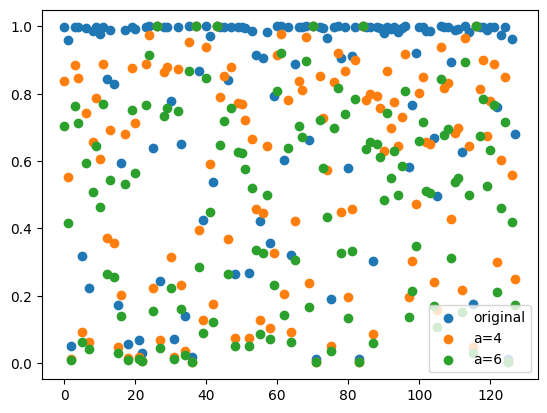

In [9]:
import cv2
from Dataloaders import dataloader_cifar10

_, _, val = dataloader_cifar10.Dataloader_cifar10_val()

from Models import mobilenetv2

model = mobilenetv2.MobileNetV2(num_classes=10)
model.load_state_dict(torch.load('./Weights/cifar-10/pretrained/mobilenetv2.pth'))
model.eval()
model.cuda()

import numpy as np

for ind, (img, label) in enumerate(val):
    img = img.cuda()
    label = label.cuda()
    output = model(img)
    output = torch.nn.functional.softmax(output, dim=1)
    conf = output.gather(1, label.view(-1,1))
   
    break

x = [x for x in range(128)]
y = conf.cpu().detach().numpy().flatten()
import matplotlib.pyplot as plt
plt.scatter(x, y, label='original')

# new_y = gate_normal(0.1, y)
# plt.scatter(x, new_y)

def gate_normal2(a, x):
    return (a*x)**3/(a**3)

new_y2 = gate_normal2(10, y)
# plt.scatter(x, new_y2)

def gate_normal3(a, x):
    return 1-(-x+1)**(1/a)

new_y3 = gate_normal3(4, y)
# torch_y = torch.tensor(y)
# new_y4 = 1-torch.pow(1-torch_y, 1/5)
plt.scatter(x, new_y3, label = 'a=4')

# new_y3 = gate_normal3(5, y)
# torch_y = torch.tensor(y)
# new_y4 = 1-torch.pow(1-torch_y, 1/5)
# plt.scatter(x, new_y3, label = 'a=5')

new_y4 = gate_normal3(6, y)
plt.scatter(x, new_y4, label = 'a=6')
plt.legend()
plt.show()

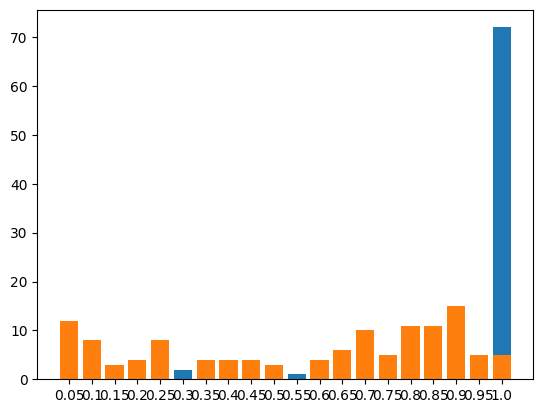

In [10]:
# show the number of 0.1 - 1.0
distribution = []
for i in range(1,21):
    distribution.append(len(np.where(y < i/20)[0]) - len(np.where(y < (i-1)/20)[0]))
plt.bar([str(i/20) for i in range(1, 21)], distribution)

# normalization
distribution = []
for i in range(1,21):
    distribution.append(len(np.where(new_y3 < i/20)[0]) - len(np.where(new_y3 < (i-1)/20)[0]))
plt.bar([str(i/20) for i in range(1, 21)], distribution)
plt.show()

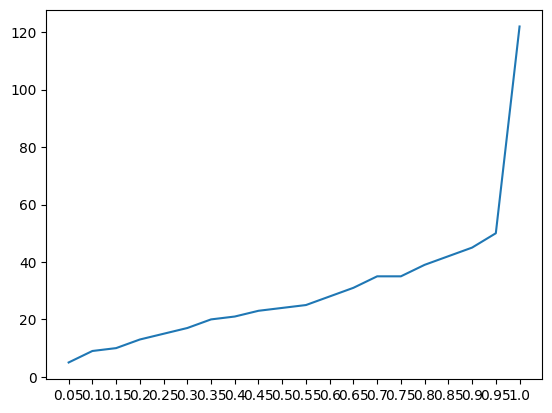

In [34]:
# plot the cdf 
cdf = []
for i in range(1,21):
    cdf.append(len(np.where(y < i/20)[0]))
plt.plot([str(i/20) for i in range(1, 21)], cdf)
plt.show()

[-0.89814396  1.          1.8536743   1.        ]


/tmp/ipykernel_3158352/2356305289.py:8: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, np.array([i/length for i in range(1, length+1)]), samples, p0=[1, 1, 1, 1])


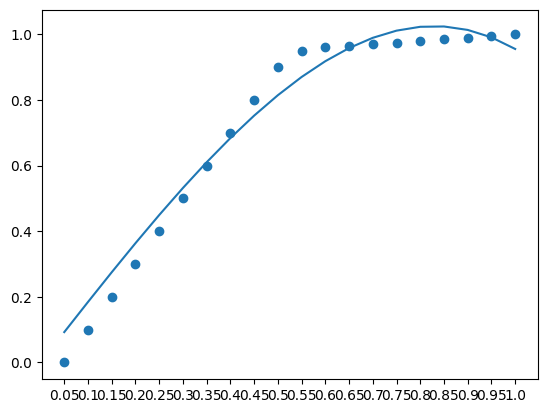

In [61]:
# curve fitting
from scipy.optimize import curve_fit
def func(x, a, b, c, d):
    return a*x**3 + c*x 

samples = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.96, 0.965, 0.97, 0.975, 0.98, 0.985, 0.99, 0.995, 1.0]
length = len(samples)
popt, pcov = curve_fit(func, np.array([i/length for i in range(1, length+1)]), samples, p0=[1, 1, 1, 1])
print(popt)
# plot samples
plt.scatter([str(i/length) for i in range(1, length+1)], samples)
plt.plot([str(i/length) for i in range(1, length+1)], func(np.array([i/length for i in range(1, length+1)]), *popt))
plt.show()


In [5]:
a = 0.95
from Utils import utils
import torch
b = utils.gate_normal3(6, torch.tensor([a]))
print(b)

c = utils.gate_renormal3(6, torch.tensor([b]))
print(c)

tensor([0.3930])
tensor([0.9500])


Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 79/79 [02:21<00:00,  1.79s/it]


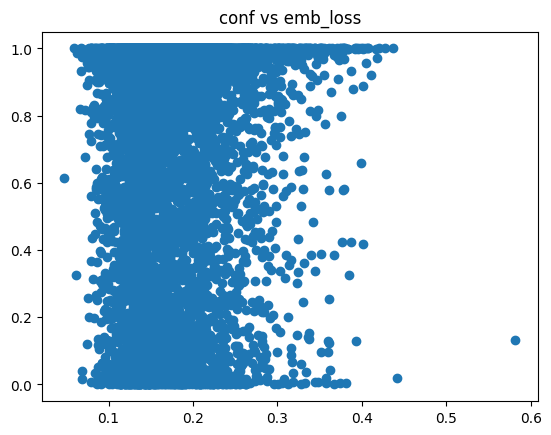

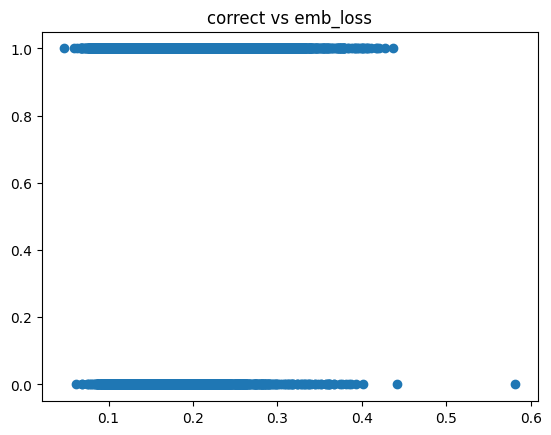

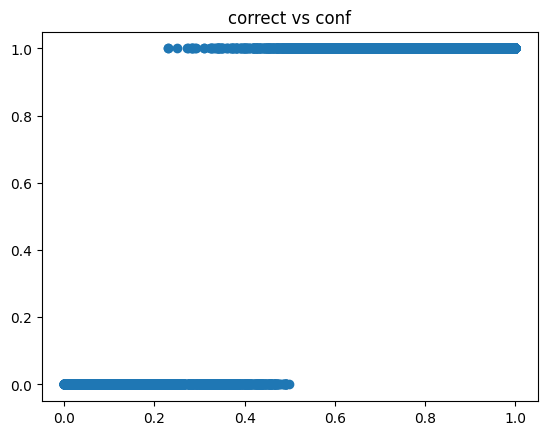

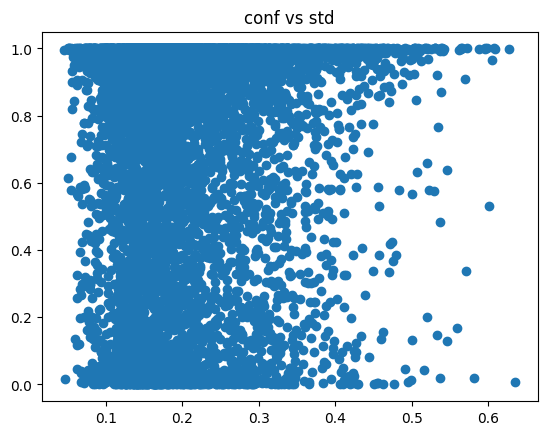

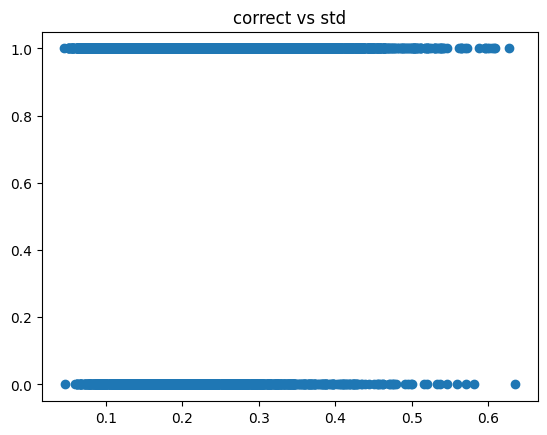

In [43]:
from Models import mobilenetv2
import torch
middle_size = 4
client, server = mobilenetv2.mobilenetv2_splitter(num_classes=10, weight_root='./Weights/cifar-10/')
middle = mobilenetv2.MobileNetV2_middle(middle=middle_size)

middle.load_state_dict(torch.load('./model_middle_%s.pth'%str(middle_size)))

client.eval()
middle.eval()
server.eval()
client.cuda()
middle.cuda()
server.cuda()

# loss = torch.nn.MSELoss()
def loss(x, y):
    ret = []
    # calculate the loss of each pixel
    for j in range(x.size(1)):
        for k in range(x.size(2)):
            ret.append(torch.nn.functional.mse_loss(x[:,j,k], y[:,j,k]).cpu().detach().numpy())
    return(ret)

import numpy as np

def get_mean_std(err):
    err = np.array(err)
    return np.mean(err), np.std(err)
from Dataloaders import dataloader_cifar10

_, _, val = dataloader_cifar10.Dataloader_cifar10_val()

emb_loss = []
conf_list = []
correct = []
mean_list =[]
std_list = []

from tqdm import tqdm
for ind, (img, label) in enumerate(tqdm(val)):
    img = img.cuda()
    label = label.cuda()
    
    out = client(img).detach()
    out2 = middle(out).detach()

    conf = server(out)
    conf = torch.nn.functional.softmax(conf, dim=1)

    result = torch.argmax(conf, dim=1)

    conf = conf.gather(1, label.view(-1,1))

    for i in range(img.size(0)):
        # emb_loss.append(loss(out2[i], out[i]).cpu().detach().numpy())
        err = loss(out2[i], out[i])
        mean, std = get_mean_std(err)
        emb_loss.append(mean)
        correct.append((result[i].item() == label[i]).cpu().detach().numpy())
        conf_list.append(conf[i].cpu().detach().numpy())
        std_list.append(std)

from matplotlib import pyplot as plt
plt.scatter(emb_loss, conf_list)
plt.title('conf vs emb_loss')
plt.show()
plt.scatter(emb_loss, correct)
plt.title('correct vs emb_loss')
plt.show()
plt.scatter(conf_list, correct)
plt.title('correct vs conf')
plt.show()
plt.scatter(std_list, conf_list)
plt.title('conf vs std')
plt.show()
plt.scatter(std_list, correct)
plt.title('correct vs std')
plt.show()

In [ ]:
# print the output of the middle layer
for ind, (img, label) in enumerate(tqdm(val)):
    img = img.cuda()
    label = label.cuda()
    
    out = client(img).detach()
    out2 = middle(out).detach()

    conf = server(out)
    conf = torch.nn.functional.softmax(conf, dim=1)

    result = torch.argmax(conf, dim=1)

    conf = conf.gather(1, label.view(-1,1))
